### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

#### Read in a single calibration image and find the corners

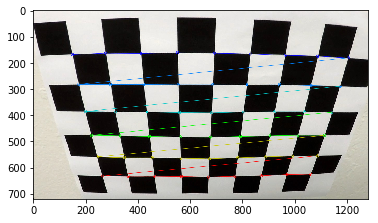

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Read in a calibration image
img = mpimg.imread("./camera_cal/calibration2.jpg")

# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points
nx = 9
ny = 6
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

# Convert image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If corners are found, add object and image points
if (ret == True):
    imgpoints.append(corners)
    imgpoints.append(objp)
    # Draw and display the corners
    img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)

#### Now do this with all calibration images available

In [2]:
import glob

# Read in and make a list of calibration images
images = glob.glob("./camera_cal/calibration*.jpg")

# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points
nx = 9
ny = 6
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

for fname in sorted(images):
    # read in each image
    img = mpimg.imread(fname)

    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If corners are found, add object and image points
    if (ret == True):
        imgpoints.append(corners)
        objpoints.append(objp)
    else:
        print("Warning: No corners found in image file %s!" % fname)


#### Calibrate the camera and undistort one image

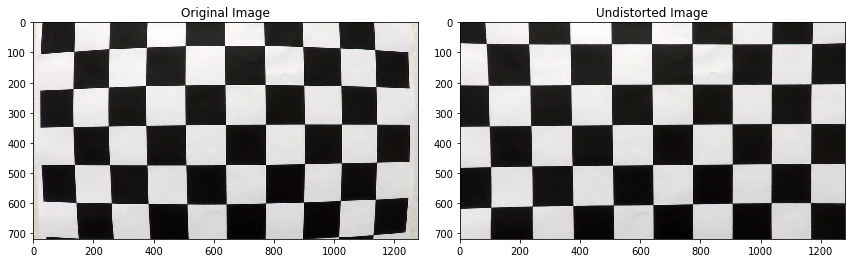

In [3]:
# Calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Undistort one image, where corners couldn't be found in step above
img = mpimg.imread("./camera_cal/calibration1.jpg")
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Plot original and undistorted image
f, ax = plt.subplots(1, 2, figsize=(12, 6))
f.tight_layout()
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[1].imshow(dst)
ax[1].set_title('Undistorted Image')
f.show(False)

### Apply a distortion correction to raw images

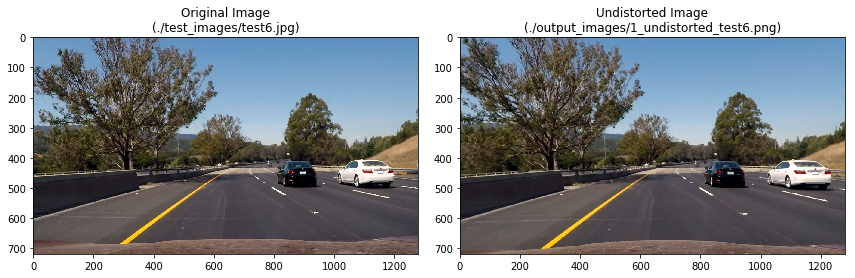

In [4]:
import os

# Read in test images, undistort them and save them into output folder
images = glob.glob("./test_images/*.jpg")
for fname_in in sorted(images):
    img = cv2.imread(fname_in)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    fname_out = "./output_images/1_undistorted_%s.png" % os.path.splitext(os.path.basename(fname_in))[0]
    cv2.imwrite(fname_out, dst)

# Plot one original image and its corresponding undistorted image
f, ax = plt.subplots(1, 2, figsize=(12, 6))
f.tight_layout()
ax[0].imshow(img[:,:,::-1])
ax[0].set_title("Original Image\n(%s)" % fname_in)
ax[1].imshow(dst[:,:,::-1])
ax[1].set_title("Undistorted Image\n(%s)" % fname_out)
f.show(False)

### Use color transforms, gradients, etc., to create a thresholded binary image

#### Define threshold functions (taken from quizzes)

In [5]:
def general_threshold(image, thresh = (90, 255)):
    # 1) Create a binary mask where thresholds are met
    binary_output = np.zeros_like(image)
    binary_output[(image > thresh[0]) & (image <= thresh[1])] = 1
    # 2) Return this mask as binary_output image
    return(binary_output)

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def absolute_sobel_threshold(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    if (orient == 'x'):
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 2) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 4) Return binary mask
    return(general_threshold(scaled_sobel, thresh))

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def magnitude_threshold(image, sobel_kernel=3, thresh=(0, 255)):
    # 1) Take the gradient in x and y separately
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 2) Calculate the magnitude
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    # 3) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 4) Return binary mask
    return(general_threshold(scaled_sobel, thresh))

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def direction_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Take the gradient in x and y separately
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 2) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx) 
    abs_sobely = np.absolute(sobely) 
    # 3) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 4) Return binary mask
    return(general_threshold(grad_dir, thresh))

#### Define combination function

In [6]:
# Combine several threshold functions
def combined_threshold(image):
    # Apply mask for region of interest
    xsize = image.shape[1]
    ysize = image.shape[0]
    vertices = np.array([[(0, ysize), (xsize*0.45, ysize*0.5), (xsize*0.55, ysize*0.5), (xsize, ysize)]], dtype=np.int32)
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, vertices, [1, 1, 1])
    image_masked = image * mask

    # Get appropriate color channels
    l_channel = cv2.cvtColor(image_masked, cv2.COLOR_BGR2LUV)[:,:,0] # best for white lines
    b_channel = cv2.cvtColor(image_masked, cv2.COLOR_BGR2Lab)[:,:,2] # best for yellow lines

    # Apply threshold function
    l_thresh = general_threshold(l_channel, thresh = (220, 255))
    b_thresh = general_threshold(b_channel, thresh = (180, 255))

    # Combine results
    binary_output = np.zeros_like(image)
    binary_output[(l_thresh == 1) | (b_thresh == 1)] = 255

    return(binary_output)

#### Calculate thresholds for test images

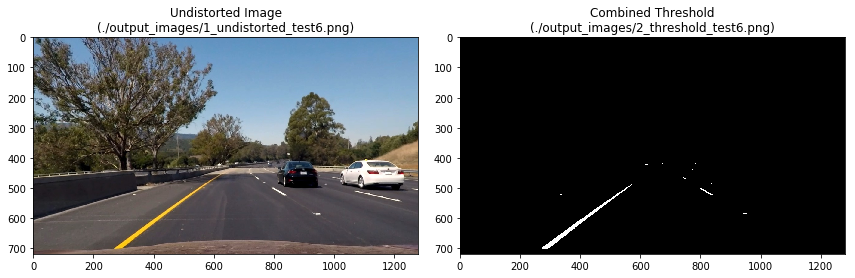

In [7]:
# Read in undistorted images, calculate threshold and save them into output folder
images = glob.glob("./output_images/1_undistorted_*.png")
for fname_in in sorted(images):
    img = cv2.imread(fname_in)
    thresh = combined_threshold(img)
    fname_out = fname_in.replace("1_undistorted_", "2_threshold_")
    cv2.imwrite(fname_out, thresh)

# Plot one original image and its corresponding undistorted image
f, ax = plt.subplots(1, 2, figsize=(12, 6))
f.tight_layout()
ax[0].imshow(img[:,:,::-1])
ax[0].set_title("Undistorted Image\n(%s)" % fname_in)
ax[1].imshow(thresh, cmap="gray")
ax[1].set_title("Combined Threshold\n(%s)" % fname_out)
f.show(False)

### Apply a perspective transform to rectify binary image ("birds-eye view")

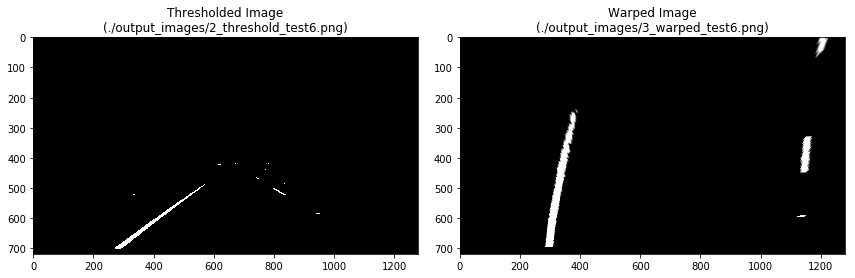

In [8]:
src = np.float32([[548, 483],  [740, 483], [1053, 690], [261, 690]])
dst = np.float32([[261, 200], [1053, 200], [1053, 690], [261, 690]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# Define perspective transform function
def warp(image):
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return(warped)

# Read in thresholded images, warp and save them into output folder
images = glob.glob("./output_images/2_threshold_*.png")
for fname_in in sorted(images):
    img = cv2.imread(fname_in)[:,:,0]
    warped = warp(img)
    fname_out = fname_in.replace("2_threshold_", "3_warped_")
    cv2.imwrite(fname_out, warped)

# Plot one thresholded image and its corresponding warped image
f, ax = plt.subplots(1, 2, figsize=(12, 6))
f.tight_layout()
ax[0].imshow(img, cmap="gray")
ax[0].set_title("Thresholded Image\n(%s)" % fname_in)
ax[1].imshow(warped, cmap="gray")
ax[1].set_title("Warped Image\n(%s)" % fname_out)
f.show(False)

### Detect lane pixels and fit to find the lane boundary

In [9]:
def find_and_fit(binary_warped, draw=False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    if (draw == True):
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return(left_fit, right_fit)

def fit_only(binary_warped, left_fit, right_fit, draw=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if (draw == True):
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    return(left_fit, right_fit)

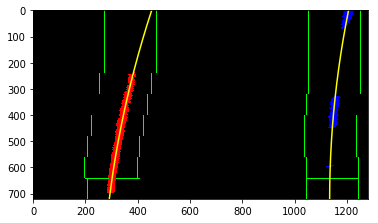

In [10]:
# Find lane line and fit polynomial
binary_warped = cv2.imread("./output_images/3_warped_test6.png")[:,:,0]
(left_fit, right_fit) = find_and_fit(binary_warped, draw=True)

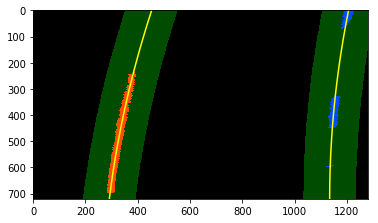

In [11]:
# Just fit polynomial with previously found lane
(left_fit, right_fit) = fit_only(binary_warped, left_fit, right_fit, draw=True)

### Determine the curvature of the lane and vehicle position with respect to center

In [12]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def calculate_curvature(image, left_fit, right_fit):
    ploty = np.linspace(0, image.shape[0]-1, num=image.shape[0])
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*image.shape[0]*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*image.shape[0]*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return(left_curverad, right_curverad)

def calculate_offset(image, left_fit, right_fit):
    leftx  = left_fit[0]*image.shape[0]**2  + left_fit[1]*image.shape[0]  + left_fit[2]
    rightx = right_fit[0]*image.shape[0]**2 + right_fit[1]*image.shape[0] + right_fit[2]
    middle = (leftx + rightx)/2
    offset = (image.shape[1]/2 - middle)*xm_per_pix
    return(offset)

# Read in warped images, find lane lines and calculate curvature and offset
images = glob.glob("./output_images/3_warped_*.png")
for fname_in in sorted(images):
    binary_warped = cv2.imread(fname_in)[:,:,0]
    (left_fit, right_fit) = find_and_fit(binary_warped)
    left_curverad, right_curverad = calculate_curvature(binary_warped, left_fit, right_fit)
    offset = calculate_offset(binary_warped, left_fit, right_fit)
    print("%s: Curvature: %.2f m / %.2f m / Offset: %.2f m" % (fname_in, left_curverad, right_curverad, offset))

./output_images/3_warped_straight_lines1.png: Curvature: 8397.25 m / 2272.44 m / Offset: -0.08 m
./output_images/3_warped_straight_lines2.png: Curvature: 6200.58 m / 16064.46 m / Offset: -0.11 m
./output_images/3_warped_test1.png: Curvature: 439.56 m / 3175.29 m / Offset: -0.31 m
./output_images/3_warped_test2.png: Curvature: 875.24 m / 1619.23 m / Offset: -0.54 m
./output_images/3_warped_test3.png: Curvature: 1023.72 m / 837.78 m / Offset: -0.23 m
./output_images/3_warped_test4.png: Curvature: 1153.78 m / 396.04 m / Offset: -0.46 m
./output_images/3_warped_test5.png: Curvature: 14413.02 m / 6064.63 m / Offset: -0.04 m
./output_images/3_warped_test6.png: Curvature: 1165.12 m / 1184.49 m / Offset: -0.38 m


### Warp the detected lane boundaries back onto the original image

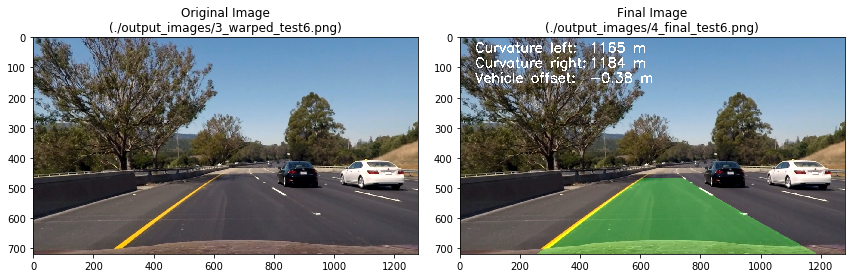

In [13]:
# Read in warped images, find lane lines and draw lane area in original image
images = glob.glob("./output_images/3_warped_*.png")
for fname_in in sorted(images):
    binary_warped = cv2.imread(fname_in)[:,:,0]
    undist = cv2.imread(fname_in.replace("3_warped_", "1_undistorted_"))
    (left_fit, right_fit) = find_and_fit(binary_warped)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, binary_warped.shape[0]-1, num=binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    # Add text for curvature and offset
    left_curverad, right_curverad = calculate_curvature(binary_warped, left_fit, right_fit)
    offset = calculate_offset(binary_warped, left_fit, right_fit)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, "Curvature left:",  (50,  50), font, 1.5, (255,255,255), 4)
    cv2.putText(result, "Curvature right:", (50, 100), font, 1.5, (255,255,255), 4)
    cv2.putText(result, "Vehicle offset:",  (50, 150), font, 1.5, (255,255,255), 4)
    cv2.putText(result, "%.0f m" % left_curverad,  (430,  50), font, 1.5, (255,255,255), 4)
    cv2.putText(result, "%.0f m" % right_curverad, (430, 100), font, 1.5, (255,255,255), 4)
    cv2.putText(result, "%.2f m" % offset,         (430, 150), font, 1.5, (255,255,255), 4)
    fname_out = fname_in.replace("3_warped_", "4_final_")
    cv2.imwrite(fname_out, result)

# Plot one original image and its corresponding final image
f, ax = plt.subplots(1, 2, figsize=(12, 6))
f.tight_layout()
ax[0].imshow(undist[:,:,::-1])
ax[0].set_title("Original Image\n(%s)" % fname_in)
ax[1].imshow(result[:,:,::-1])
ax[1].set_title("Final Image\n(%s)" % fname_out)
f.show(False)

### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

In [14]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # maximum number of fit coefficients to remember
        self.n_fits = 15
        # last n fit coefficients
        self.last_fits = []

In [15]:
from moviepy.editor import VideoFileClip

left_line = Line()
right_line = Line()

def process_image(image):
    global left_line
    global right_line
    
    # do the image processing: undistort, color threshold and warp
    image = image[:,:,::-1]
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    thresh = combined_threshold(undist)[:,:,0]
    warped = warp(thresh)

    # find lane lines in warped image
    if ((left_line.detected == False) or (right_line.detected == False)):
        # no lines detected so far, we have to find them first
        (left_fit, right_fit) = find_and_fit(warped)
        left_line.last_fits = np.array([left_fit], ndmin=2)
        right_line.last_fits = np.array([right_fit], ndmin=2)
        left_line.detected = True
        right_line.detected = True
    else:
        try:
            # lines have been detected in previous step, so use that values
            (left_fit, right_fit) = fit_only(warped, left_line.last_fits[-1], right_line.last_fits[-1])
            # Calculate average over last n lines
            left_line.last_fits = np.append(left_line.last_fits, [left_fit], axis=0)
            right_line.last_fits = np.append(right_line.last_fits, [right_fit], axis=0)
            if (len(left_line.last_fits) > left_line.n_fits):
                left_line.last_fits =  left_line.last_fits[1:] # throw away oldest values
            if (len(right_line.last_fits) > right_line.n_fits):
                right_line.last_fits = right_line.last_fits[1:] # throw away oldest values
            left_fit = np.mean(left_line.last_fits, axis=0)
            right_fit = np.mean(right_line.last_fits, axis=0)
        except:
            try:
                # ups, we lost the lines, so find them from scratch
                (left_fit, right_fit) = find_and_fit(warped)
                left_line.last_fits = np.array([left_fit], ndmin=2)
                right_line.last_fits = np.array([right_fit], ndmin=2)
            except:
                # uiuiui, we can't find the lines at all, so take the last ones
                (left_fit, right_fit) = (left_line.last_fits[-1], right_line.last_fits[-1])
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, warped.shape[0]-1, num=warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    # Add text for curvature and offset
    left_curverad, right_curverad = calculate_curvature(binary_warped, left_fit, right_fit)
    offset = calculate_offset(binary_warped, left_fit, right_fit)
    cv2.putText(result, "Curvature:",  (50,  50), font, 1.5, (64,64,255), 4)
    cv2.putText(result, "%.0f m" % ((left_curverad+right_curverad)/2), (430,  50), font, 1.5, (0,255,255), 4)
    cv2.putText(result, "Vehicle offset:", (50, 100), font, 1.5, (64,64,255), 4)
    cv2.putText(result, "%.2f m" % offset, (430, 100), font, 1.5, (0,255,255), 4)
    return(result[:,:,::-1])

In [16]:
# Finally process the project video
clip_in = VideoFileClip("project_video.mp4")
clip_out = clip_in.fl_image(process_image)
%time clip_out.write_videofile("project_video_final.mp4", audio=False)

[MoviePy] >>>> Building video project_video_final.mp4
[MoviePy] Writing video project_video_final.mp4


100%|█████████▉| 1260/1261 [03:24<00:00,  6.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_final.mp4 

CPU times: user 5min 28s, sys: 3.43 s, total: 5min 32s
Wall time: 3min 26s
